__Домашнее задание к уроку №3__

1. Обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта

Загрузим датасет и подготовим данные:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
!wget 'https://drive.google.com/uc?export=download&id=1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G' -O train_case2.csv

--2022-04-01 08:50:46--  https://drive.google.com/uc?export=download&id=1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G
Resolving drive.google.com (drive.google.com)... 142.250.141.100, 142.250.141.101, 142.250.141.138, ...
Connecting to drive.google.com (drive.google.com)|142.250.141.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vj1mri7tlcp8k1ao6e9caddvi4ktofvi/1648803000000/14904333240138417226/*/1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G?e=download [following]
--2022-04-01 08:50:47--  https://doc-00-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vj1mri7tlcp8k1ao6e9caddvi4ktofvi/1648803000000/14904333240138417226/*/1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G?e=download
Resolving doc-00-c0-docs.googleusercontent.com (doc-00-c0-docs.googleusercontent.com)... 142.250.141.132, 2607:f8b0:4023:c0b::84
Connecting to doc-00-c0-docs.googleusercontent.com (doc-00-c0

In [3]:
df = pd.read_csv('train_case2.csv', ';')
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [4]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='cardio'), 
                                                    df['cardio'], random_state=0)

К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [5]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [6]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

Добавим классификатор Logistic Regression и запустим кросс-валидацию

In [51]:
classifier_LR = Pipeline([
    ('features', feats),
    ('classifier', LogisticRegression(random_state=42)),
])


# запустим кросс-валидацию
cv_scores = cross_val_score(classifier_LR, X_train, y_train, cv=7, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print(f'CV score is {cv_score}+-{cv_score_std}')

# обучим пайплайн на всем тренировочном датасете
classifier_LR.fit(X_train, y_train)
y_score = classifier_LR.predict_proba(X_test)[:, 1]

CV score is 0.7864573689384385+-0.004422021036885763


In [52]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix

b = 1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1 +b**2) * (precision * recall) / (b**2 * precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.3869370891147379, F-Score=0.730, Precision=0.647, Recall=0.838


Построим матрицу ошибок.

In [53]:
cnf_matrix_LR = confusion_matrix(y_test, y_score > thresholds[ix])
cnf_matrix_LR

array([[4861, 3959],
       [1411, 7269]])

In [47]:
TN = cnf_matrix_LR[0][0]
FN = cnf_matrix_LR[1][0]
TP = cnf_matrix_LR[1][1]
FP = cnf_matrix_LR[0][1]

Оценим расходы, если делать тест по совету модели LR:

In [23]:
rubl_test = 1400
rubl_early_treatment = 15000
rubl_late_treatment = 20000

In [24]:
expenses_LR = (FP + TP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment
print('расходы, если использовать LR:', expenses_LR)

расходы, если использовать LR: 152974200


Сохраним метрики для модели LR.

In [25]:
data_LR = [precision[ix], recall[ix], fscore[ix], cv_score]
data_LR

[0.6474307596402173,
 0.8375576036866359,
 0.7303229695112764,
 0.7864573689384385]

Проделаем то же самое для классификатора Gradient Boosting.

In [26]:
classifier_GB = Pipeline([
    ('features', feats),
    ('classifier_GB', GradientBoostingClassifier(random_state=42)),
])


# запустим кросс-валидацию
cv_scores = cross_val_score(classifier_GB, X_train, y_train, cv=7, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print(f'CV score is {cv_score}+-{cv_score_std}')

# обучим пайплайн на всем тренировочном датасете
classifier_GB.fit(X_train, y_train)
y_score = classifier_GB.predict_proba(X_test)[:, 1]

CV score is 0.8023336401314394+-0.003067762759094604


In [27]:
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1 +b**2) * (precision * recall) / (b**2 * precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.39494659702686624, F-Score=0.740, Precision=0.698, Recall=0.788


Построим матрицу ошибок.

In [28]:
cnf_matrix = confusion_matrix(y_test, y_score > thresholds[ix])
cnf_matrix

array([[5858, 2962],
       [1840, 6840]])

In [29]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

Оценим расходы, если делать тест по совету модели GB:

In [30]:
expenses_GB = (FP + TP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment
print('расходы, если использовать LR:', expenses_GB)

расходы, если использовать LR: 153122800


Сохраним метрики для модели GB.

In [31]:
data_GB = [precision[ix], recall[ix], fscore[ix], cv_score]
data_GB

[0.6978475976741814,
 0.7881336405529954,
 0.7402477952713303,
 0.8023336401314394]

И теперь обучим модель Randon Forest Classifier.

In [32]:
classifier_RF = Pipeline([
    ('features', feats),
    ('classifier_RF', RandomForestClassifier(random_state=42)),
])


# запустим кросс-валидацию
cv_scores = cross_val_score(classifier_RF, X_train, y_train, cv=7, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print(f'CV score is {cv_score}+-{cv_score_std}')

# обучим пайплайн на всем тренировочном датасете
classifier_RF.fit(X_train, y_train)
y_score = classifier_RF.predict_proba(X_test)[:, 1]

CV score is 0.7743796633622809+-0.003611330100912611


In [33]:
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1 +b**2) * (precision * recall) / (b**2 * precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.35, F-Score=0.719, Precision=0.643, Recall=0.816


Построим матрицу ошибок.

In [34]:
cnf_matrix = confusion_matrix(y_test, y_score > thresholds[ix])
cnf_matrix

array([[4991, 3829],
       [1663, 7017]])

In [36]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

Оценим расходы, если делать тест по совету модели RF:

In [37]:
expenses_RF = (FP + TP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment
print('расходы, если использовать LR:', expenses_RF)

расходы, если использовать LR: 153699400


Сохраним метрики для модели RF.

In [38]:
data_RF = [precision[ix], recall[ix], fscore[ix], cv_score]
data_RF

[0.6426690876078075,
 0.8155529953917051,
 0.7188626554963188,
 0.7743796633622809]

2. Вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)

In [39]:
ML_metrics = pd.DataFrame([data_LR, data_GB, data_RF], index = ['LR', 'GB', 'RF'], columns = ['precision', 'recall', 'fscore', 'roc_auc'])
ML_metrics

,precision,recall,fscore,roc_auc
LR,0.647431,0.837558,0.730323,0.786457
GB,0.697848,0.788134,0.740248,0.802334
RF,0.642669,0.815553,0.718863,0.774380


Метрики качества рассмотренных моделей классификации при использовании их гиперпараметров по умолчанию различаются незначительно. Лучше всех себя показала модель градиентного бустинга.

3. Вывести сравнение полученных моделей по метрикам бизнеса по показателям с урока
    - стоимость лечения 15000р, если сделали тест и начали лечить вовремя
    - стоимость лечения 20000р, если упустили и начали лечить когда уже проявились все симптомы
    - стоимость теста 1400р

  Сделать выводы о том, какая модель справилась с задачей лучше других.

In [43]:
business_metrics = pd.DataFrame([expenses_LR, expenses_GB, expenses_RF], index = ['LR', 'GB', 'RF'])
business_metrics

,0
LR,152974200
GB,153122800
RF,153699400


Несмотря на то, что по ML метрикам выигрывала модель GB, по бизнес метрикам лучше других себя проявила модель LR. Это обусловлено тем, что у нее самая высокая полнота определения целевого класса. А цена ошибок FN в данной бизнес задаче велика. Поэтому для каждой конкретной бизнес задачи необходимо определять целевую ML метрику, которая корелирует с целевой бизнес метрикой.

4. (*)Найти порог классификации по деньгам для лучшей модели
    - Стоимость лечения 15000р, если сделали тест и начали лечить вовремя
    - Стоимость лечения 20000р, если упустили и начали лечить когда уже проявились все симптомы
    - Стоимость теста 1400р

Лучше всего по расходам показала себя модель LR, оптимизируем ее порог классификации. Для этого напишем функцию поиска наилучшей отсечки.

In [59]:
def business_threshold_calibrate(y_test, y_score, thresholds,
                                 rubl_test=100, rubl_early_treatment=100, rubl_late_treatment=1000):
    business_threshold = 0
    r_test_all_r_ML_ = 0

    rubl_ML_ = 1000000000

    rs = []
    n = 20
    for opt_buisness_tr in np.linspace(0, 1, n).tolist():
        # подберем порог для улучшения бизнесс показателя

        cnf_matrix = confusion_matrix(y_test, y_score > (opt_buisness_tr))
        TN = cnf_matrix[0][0]
        FN = cnf_matrix[1][0]
        TP = cnf_matrix[1][1]
        FP = cnf_matrix[0][1]

        rubl_1 = (TP + FN) * rubl_late_treatment
        rubl_test_all = np.sum(cnf_matrix) * rubl_test + (FN + TP) * rubl_early_treatment
        rubl_ML = (TP + FP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment
        
        r_test_all_r_ML = rubl_test_all - rubl_ML 
        
        if rubl_ML < rubl_ML_:            
            business_threshold = opt_buisness_tr
            
            rubl_ML_ = rubl_ML
            
        rs.append(rubl_ML)   
            
    
    print('расходы, если не делать тест и ждать симптомов:', rubl_1)
    print('расходы, если делать тест всем и лечить группу больных:', rubl_test_all)
    print('расходы, если использовать МЛ:', rubl_ML_)

    print('Расходы "решение не делать тесты - расходы с МL:"', rubl_1 - rubl_ML_)
    print('Расходы "решение не делать тесты - расходы сделать тесты всем":', rubl_1 - rubl_test_all)
    print('Расходы "сделать тесты всем - решение делать тесты ML":', rubl_test_all - rubl_ML_)
    
    plt.title('Потери при МЛ решении')
    plt.xlabel('Отсечка')
    plt.ylabel('Потери')
    plt.plot(np.linspace(0,1,n), rs)
    plt.show()
    return business_threshold

И получим необходимый порог при заданной стоимости медицинских услуг:

расходы, если не делать тест и ждать симптомов: 173600000
расходы, если делать тест всем и лечить группу больных: 154700000
расходы, если использовать МЛ: 152712400
Расходы "решение не делать тесты - расходы с МL:" 20887600
Расходы "решение не делать тесты - расходы сделать тесты всем": 18900000
Расходы "сделать тесты всем - решение делать тесты ML": 1987600


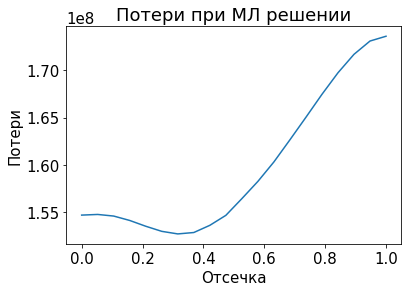

уровень порога по бизнес метрике 0.3157894736842105
уровень порога по f1 метрике 0.3869370891147379


In [60]:
busines_tr = business_threshold_calibrate(y_test, y_score, 
                                          thresholds[ix],
                                          rubl_test=1400, 
                                          rubl_early_treatment=15000, 
                                          rubl_late_treatment=20000)

print('уровень порога по бизнес метрике', busines_tr)
print('уровень порога по f1 метрике', thresholds[ix])